## [1] Problem Statement :

<b>Word Vectors Using Truncated SVD:
-  Finding the top n words using Tfidf
-  Computing the co-occurence matrix of n * n for those top n words
-  Matrix Decomposition of co-occurence matrix using Truncated SVD
-  Applying Kmeans Clustering with the wordvectors
-  Visualization of wordvectors using wordcloud

## [2] Overview of Dataset :

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.  

Number of reviews: 568,454  
Number of users: 256,059  
Number of products: 74,258  
Timespan: Oct 1999 - Oct 2012  
Number of Attributes/Columns in data: 10  

Attribute Information:

&emsp;1.Id  
&emsp;2.ProductId - unique identifier for the product  
&emsp;3.UserId - unqiue identifier for the user  
&emsp;4.ProfileName  
&emsp;5.HelpfulnessNumerator - number of users who found the review helpful  
&emsp;6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not  
&emsp;7.Score - rating between 1 and 5  
&emsp;8.Time - timestamp for the review  
&emsp;9.Summary - brief summary of the review  
&emsp;10.Text - text of the review  

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [3] Loading the Data :

In order to load the data, we have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [30]:
#Importing the necessary Packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import time
import random
from tqdm import tqdm
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle

<b>Using SQLite Table to load preprocessed data already saved in disk:</b>

In [131]:
# using the SQLite Table to read data.
conn = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """,conn) 

In [132]:
#Listing out the number of positive and negative reviews
final = final.reset_index(drop=True)
final['Score'].value_counts()

positive    306566
negative     57033
Name: Score, dtype: int64

In [133]:
final.shape

(363599, 12)

In [134]:
(final['Score'].value_counts()/len(final['Score']))*100

positive    84.314313
negative    15.685687
Name: Score, dtype: float64

In [136]:
sampled_data = final.sample(n = 100000)
sampled_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
245335,455172,492120,B002LVACUE,A1W2HEN9QS9W5Z,Elementsk892,0,0,positive,1333497600,"Great, Tasty Snack!","Loved this cereal as a kid, and still do to th...",love cereal kid still day incred hard find now...
342430,494760,534890,B005PXZ6JM,AMAJZF06BXVTA,londons first,0,0,positive,1336348800,Really great,Don't know much about milk bag brands or style...,dont know much milk bag brand style know one b...
136414,128530,139493,B00112EUPM,A2YCLNTYHY22KR,Jessica Long,1,1,positive,1299715200,"Tasty, easy nutrition",I actually bought the trial size of individual...,actual bought trial size individu packet tri t...
125530,298065,322868,B000VBSL3Q,A2079CA8KJ1YJ1,TeariNiTuP,2,4,negative,1328054400,Not worth it,This basically tasted like the other much chea...,basic tast like much cheaper evoo groceri stor...
343104,125373,136012,B005SPQENY,AFDJGY68CQL2X,"Snail Dealer ""Snail""",0,1,positive,1331078400,Delicious and chewy!,Maybe I am biased because I am from its produc...,mayb bias produc countri grew stuff delici doe...


In [264]:
X = sampled_data["CleanedText"].values
print("Shape of Input Data: ",X.shape)

Shape of Input Data:  (100000,)


## [4] Word Vectors Using Truncated SVD :

<b>Tf-idf Vectorization :</b>

In [33]:
%%time
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1),stop_words='english', strip_accents='unicode')
X_tfidf = tfidf_vect.fit_transform(X)
print("Type of count vectorizer ",type(X_tfidf))
print("Shape of out text TFIDF vectorizer ",X_tfidf.get_shape())
print("Number of unique words including both unigrams and bigrams ", X_tfidf.get_shape()[1])

Type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
Shape of out text TFIDF vectorizer  (100000, 38067)
Number of unique words including both unigrams and bigrams  38067
CPU times: user 5 s, sys: 16 ms, total: 5.02 s
Wall time: 5.02 s


In [34]:
tfidf_scores =  zip(tfidf_vect.get_feature_names(),np.asarray(X_tfidf.sum(axis = 0)).ravel())
sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse = True)

<b>Finding top n words :</b>

In [35]:
def top_n_features(n):
    
    word = []
    tfidf = []
    for i in sorted_scores[0:n]:
        word.append(i[0])
        tfidf.append(i[1])
    top_features = pd.DataFrame(np.column_stack([word,tfidf]),columns=["Word","Tfidf"])
    print(top_features["Word"].head(10))
    print(top_features.shape)
    return top_features

<b>Computing Co-occurence Matrix :</b>

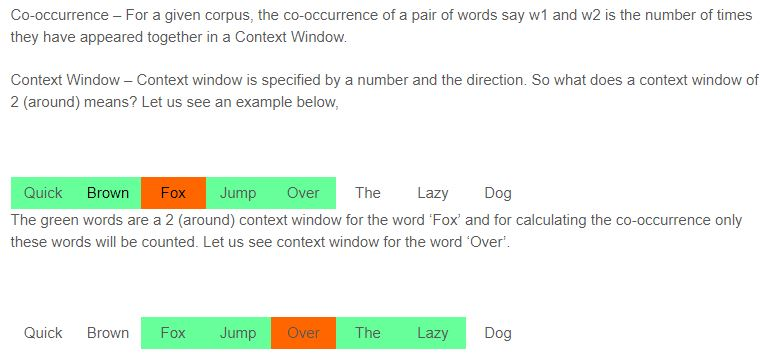

In [36]:
Image(filename = "co-occurence.JPG")

<b>Let take an example corpus to calculate a co-occurrence matrix with context  window 2</b>  

<b>Red box</b> - It is the number of times ‘He’ and ‘is’ have appeared in the context window 2 and it can be seen that the count turns out to be 4.  
<b>Blue box</b> -  word ‘lazy’ has never appeared with ‘intelligent’ in the context window and therefore has been assigned 0.

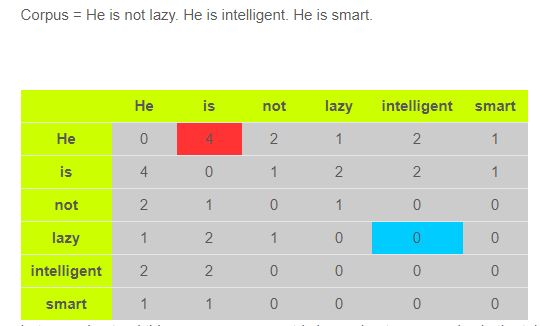

In [37]:
Image(filename = "demo.JPG")

In [38]:
corpus = ["he is not lazy he is intelligent he is smart"]
print(corpus)

vect = TfidfVectorizer(ngram_range=(1, 1))
corpus_vect = vect.fit_transform(corpus)
words = vect.get_feature_names()

C = np.zeros((len(words),len(words)))
C = pd.DataFrame(C, index = words, columns = words)
context_window = 2

for i in corpus:
    text = i.split(" ")
    for i in range(len(text)):
        for j in range(max(i - context_window,0),min(i + context_window+1,len(text))):
            if text[i] != text[j]:
                try:
                    C.loc[text[i], text[j]] += 1
                except:
                    pass
                
print(C)

['he is not lazy he is intelligent he is smart']
              he  intelligent   is  lazy  not  smart
he           0.0          2.0  4.0   1.0  2.0    1.0
intelligent  2.0          0.0  2.0   0.0  0.0    0.0
is           4.0          2.0  0.0   2.0  1.0    1.0
lazy         1.0          0.0  2.0   0.0  1.0    0.0
not          2.0          0.0  1.0   1.0  0.0    0.0
smart        1.0          0.0  1.0   0.0  0.0    0.0


In [39]:
def compute_cooccurencematrix(X,top_features,context_window):
    
    Xc = np.zeros((top_features.shape[0],top_features.shape[0]))
    Xc = pd.DataFrame(Xc, index = top_features['Word'].tolist(), columns = top_features['Word'].tolist())
    
    for review in tqdm(X):
        text = review.split(" ")
        for i in range(len(text)):
            for j in range(max(i - context_window,0),min(i + context_window+1,len(text))):
                if text[i] != text[j]:
                    try:
                        Xc.loc[text[i], text[j]] += 1
                    except:
                        pass
    print("Dimesions of Cooccuranece matrix:" , Xc.shape)
    return Xc

<b>Selecting The Best Number Of Components For TSVD :</b>

In [40]:
def best_ncomponents(x):
    
    tsvd = TruncatedSVD(n_components = x.shape[1] - 1)
    U = tsvd.fit_transform(x)
    
    percentage_var_explained = tsvd.explained_variance_ /np.sum(tsvd.explained_variance_)
    cum_var_explained = np.cumsum(percentage_var_explained)
    
    plt.figure(figsize= (10,6))
    plt.clf()
    plt.plot(cum_var_explained)
    plt.xlabel("No of components",fontsize=12,fontweight="bold")
    plt.ylabel("Cummulative explained variance",fontsize=12,fontweight="bold")
    plt.grid("on")
    plt.show()

<b>Matrix Factorization and Kmeans Clustering :</b>

In the definition of SVD, an original matrix A is decomposed as a product <b>A ≈ U Σ V*</b> where U and V have orthonormal columns, and Σ is non-negative singular values.  
Here A, is the co-occurence matrix of top n words.    
Then we apply kmeans and visualize the word vectors(U) that we get.

In [41]:
def matrix_factorization(x,n_components):

    tsvd = TruncatedSVD(n_components = n_components,random_state = 3)
    U = tsvd.fit_transform(x)
    sigma = tsvd.singular_values_
    VT = tsvd.components_
    print("Dimensions of U: ", U.shape)
    print("Dimensions of sigma: ", sigma.shape)
    print("Dimensions of U: ", VT.shape)
    print(tsvd.explained_variance_ratio_.sum())
    return U,sigma,VT



def best_k(x):
    n_clusters = list(np.arange(10,101,10))
    loss = []
    
    for k in n_clusters:
        km = KMeans(n_clusters = k)
        km.fit(x)
        loss.append(km.inertia_)
    
    #print("-------Best k using Elbow Method---------")
    plt.figure(figsize = (10,8))
    plt.plot(n_clusters,loss,'r-*')
    plt.title("Elbow Method",fontsize = 20,fontweight = "bold")
    plt.xlabel("Clusters(k)")
    plt.ylabel("Loss")
    plt.grid('on')
    plt.show()

In [42]:
def kmeans(U,n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(U)
    labels = kmeans.labels_
    
    return labels

<b>Visualisation of WordVectors: </b>

In [43]:
stopwords = set(STOPWORDS)

def words_visualisation(U,top_features,labels):
    
    wordvector = pd.DataFrame(U)
    wordvector['Label'] = labels
    wordvector['Feature'] = top_features['Word']
    
    clusters = wordvector['Label'].value_counts()
    clusters = clusters.index.tolist()
    top_clusters = clusters[:10]
    fig = plt.figure(figsize=(20,20))
    for index,val in enumerate(top_clusters):
        df = wordvector.loc[wordvector['Label'] == val]
        text = " ".join(x for x in df.Feature)
        
        wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)
        ax = fig.add_subplot(5,2,index+1)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title("Cluster {},size = {}".format(val,df.shape[0]),fontsize=15,fontweight="bold")
        ax.axis("off")
    plt.subplots_adjust(bottom=0.01, wspace=0.01)

### [4.1] For Top 2000 words :

In [15]:
top_features_2000  = top_n_features(n = 2000)

0       tast
1       like
2       love
3       good
4      great
5     flavor
6      coffe
7    product
8        tea
9        use
Name: Word, dtype: object
(2000, 2)


In [152]:
Xc_2000 = compute_cooccurencematrix(X,top_features_2000,context_window = 4)

100%|██████████| 100000/100000 [1:30:51<00:00, 18.34it/s]

Dimesions of Cooccuranece matrix: (2000, 2000)


In [17]:
#standarization of data
sc = StandardScaler(with_mean=False)
Xc_2000std = sc.fit_transform(Xc_2000)

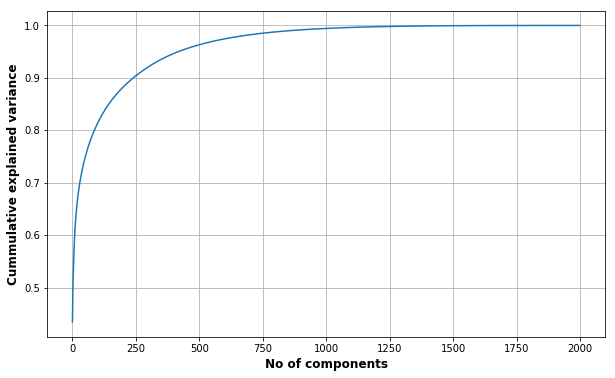

In [15]:
best_ncomponents(Xc_2000std)

<b>OBSERVATION :</b>  
It is observed from the above plot, with <b>n_components = 750 around 98% of variance is explained</b>.  
So, selecting n_components = 750.

In [18]:
%%time
U1, sigma1, VT1 = matrix_factorization(Xc_2000std,n_components=750)

Dimensions of U:  (2000, 750)
Dimensions of sigma:  (750,)
Dimensions of U:  (750, 2000)
0.9868338368067965
CPU times: user 28.8 s, sys: 216 ms, total: 29.1 s
Wall time: 2.2 s


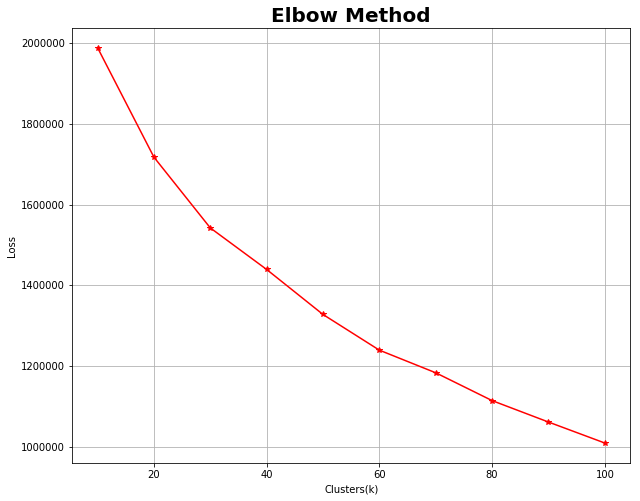

In [19]:
best_k(U1)

<b>OBSERVATION :</b>  
It is observed that around 60-70 clusters, loss reduction is very small.  
So,chosing number of clusters = 60(inflexion point).

In [20]:
labels1 = kmeans(U1,n_clusters = 60)

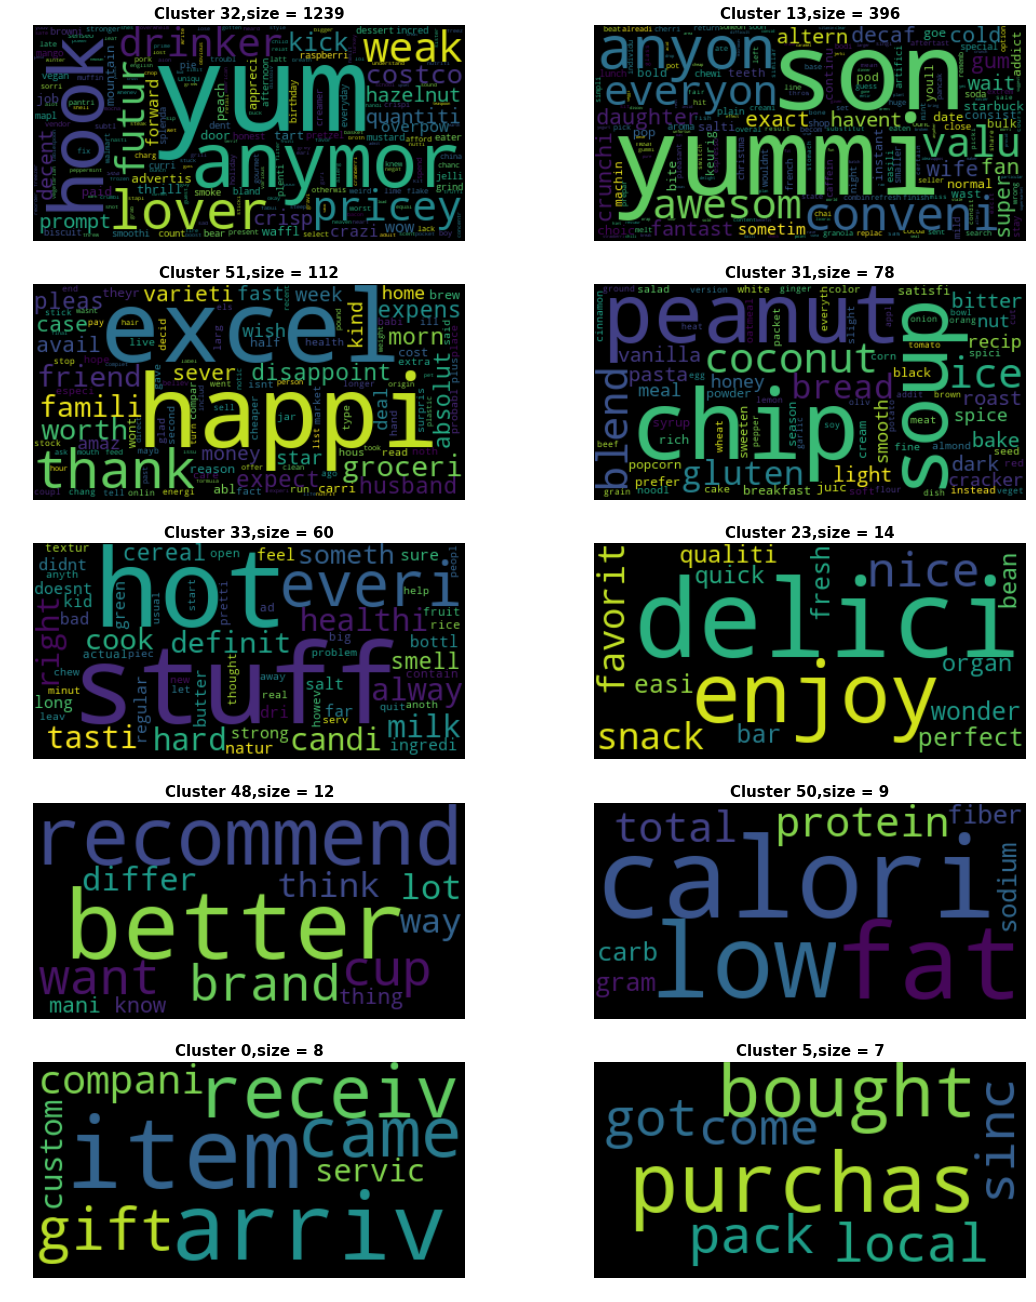

In [21]:
words_visualisation(U1,top_features_2000,labels1)

<b>OBSERVATION :</b>  
-  Cluster 50 is about <b>nutritional and diet related</b> foods as it contains terms like <b>fiber,protien,sodium,calorie,fat,carb,vitamin</b> etc. 
-  Cluster 31 is about <b>sweet and snacks</b>  as it contains terms like <b>honey,vanilla,juice,cake,popcorn,cream,peanuts </b>etc.   
-  Cluster 31 is about <b>spicy and salty realted food items</b> as it contains terms like <b> chicken,meal,beef,noodle,pepper,egg,soup,roast,spice,pasta,salt</b>.  
-  It is also observed that terms like husband,son,wife,daughter are grouped to cluster 13 as they have semantic meaning of a person's gender.
-  Some clusters do not show any pattern as it contains only one or two words.  

### [4.2] For Top 5000 words :

In [48]:
top_features_5000  = top_n_features(n = 5000)

0       tast
1       like
2       love
3       good
4      great
5     flavor
6      coffe
7    product
8        tea
9        use
Name: Word, dtype: object
(5000, 2)


In [ ]:
Xc_5000 = compute_cooccurencematrix(X,top_features_5000,context_window = 4)

In [50]:
#standardization of data
sc = StandardScaler(with_mean=False)
Xc_5000std = sc.fit_transform(Xc_5000)

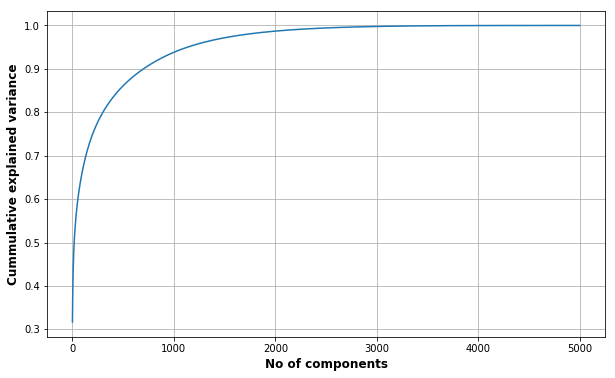

In [23]:
best_ncomponents(Xc_5000std)

<b>OBSERVATION :</b>  
It is observed from the above plot, with <b>n_components = 1700 around 98% of variance is explained</b>.  
So, selecting n_components = 1700.

In [51]:
U2, sigma2, VT2 = matrix_factorization(Xc_5000std,n_components=1700)

Dimensions of U:  (5000, 1700)
Dimensions of sigma:  (1700,)
Dimensions of U:  (1700, 5000)
0.9789813466732388


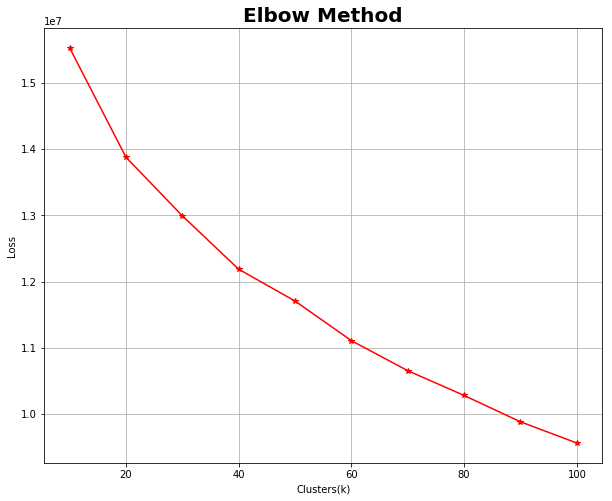

In [55]:
best_k(U2)

<b>OBSERVATION :</b>  
It is observed that around 60-70 clusters, loss reduction is very small.  
So,chosing number of clusters = 60(inflexion point).

In [56]:
labels2 = kmeans(U2,n_clusters = 60)

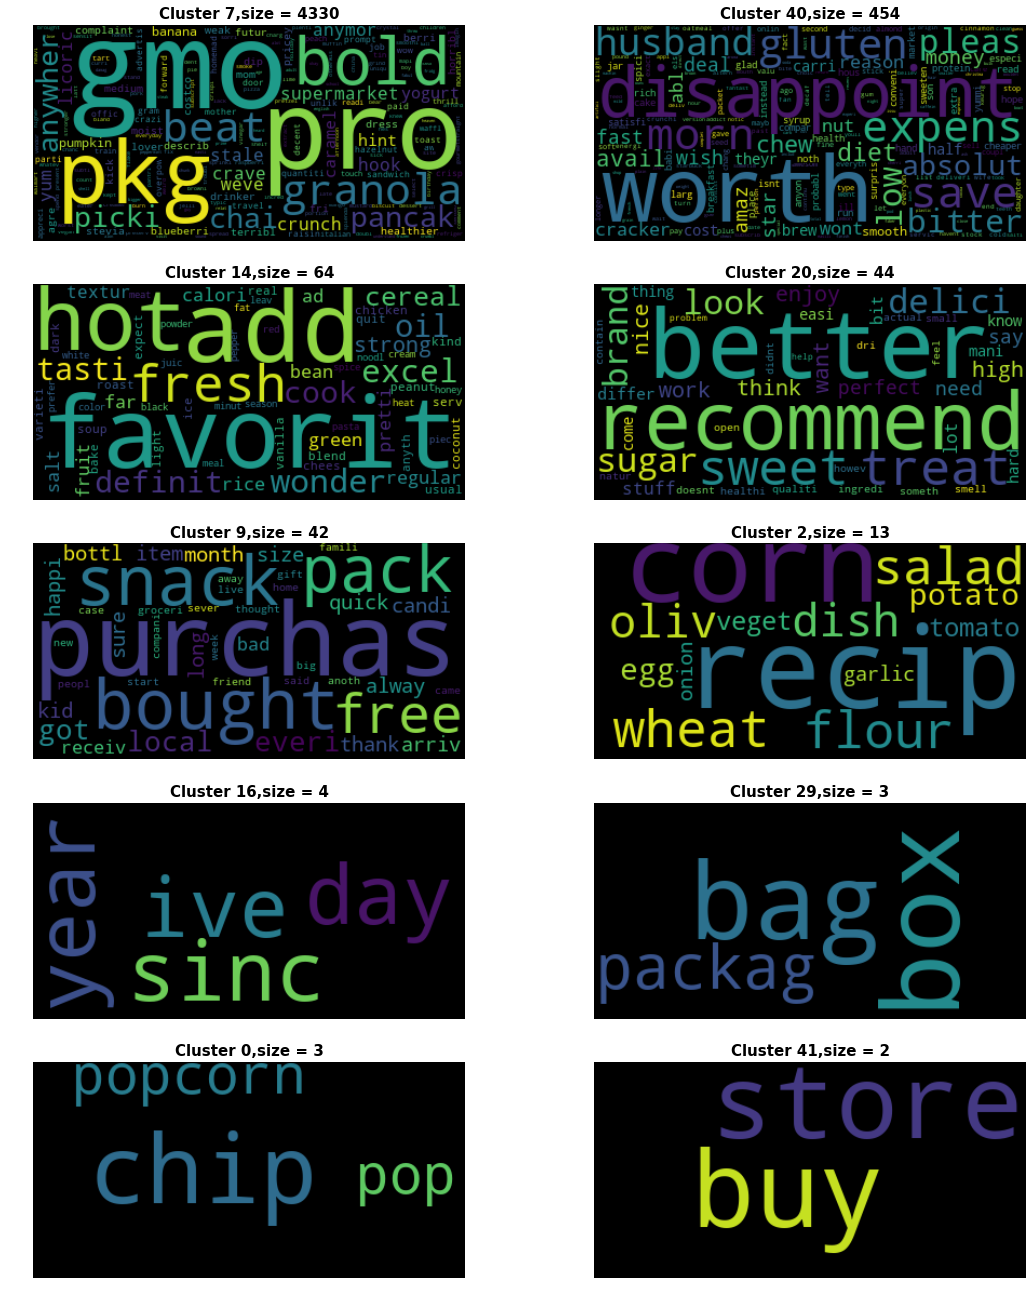

In [57]:
words_visualisation(U2,top_features_5000,labels2)

<b>OBSERVATION :</b>  
-  Cluster 14 is about <b>spicy food items</b> as it contains terms like <b>chicken,rice,meat,soup,oil,spice,noodle,hot,pasta</b> etc.  
-  Cluster 2 is about <b>vegaetables and grocery items</b>  as it contains terms like <b>potato,tomato,onion,corn,olive,garlic,wheat,flour</b> etc. 
-  It is also observed that terms like big,long,small,minut,weak are grouped to cluster 9 as they have semantic meaning of a size.

### [4.3] For Top 10000 words :

In [62]:
top_features_10000  = top_n_features(n = 10000)

0       tast
1       like
2       love
3       good
4      great
5     flavor
6      coffe
7    product
8        tea
9        use
Name: Word, dtype: object
(10000, 2)


In [ ]:
Xc_10000 = compute_cooccurencematrix(X,top_features_10000,context_window = 4)

In [64]:
#standardization of data
sc = StandardScaler(with_mean=False)
Xc_10000std = sc.fit_transform(Xc_10000)

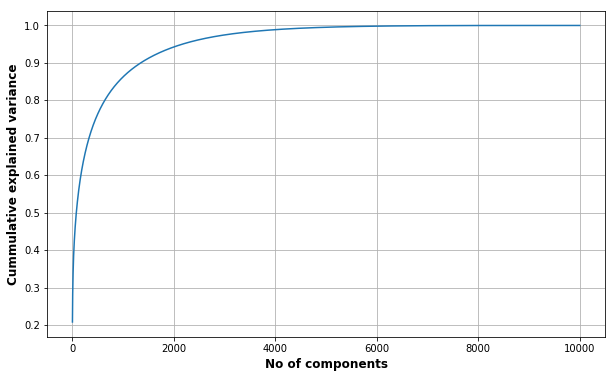

In [19]:
best_ncomponents(Xc_10000std)

<b>OBSERVATION :</b>  
It is observed from the above plot, with <b>n_components = 3500 around 98% of variance is explained</b>. 
So, selecting n_components = 3500.

In [65]:
U3, sigma3, VT3 = matrix_factorization(Xc_10000std,n_components=3500)

Dimensions of U:  (10000, 3500)
Dimensions of sigma:  (3500,)
Dimensions of U:  (3500, 10000)
0.9826501681277517


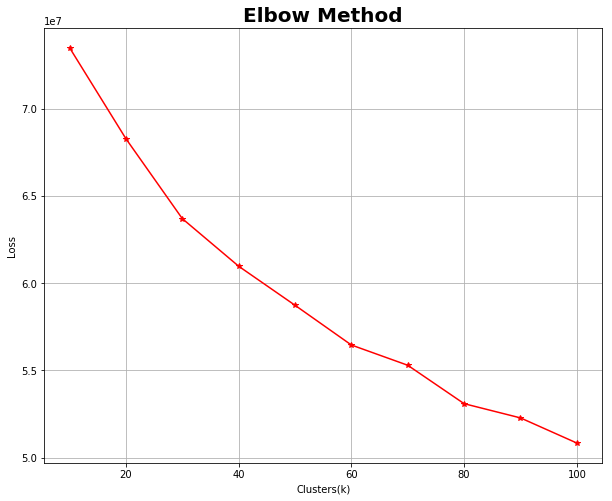

In [66]:
best_k(U3)

<b>OBSERVATION :</b>  
It is observed that around 60-70 clusters, loss reduction is very small.  
So,chosing number of clusters = 60(inflexion point).

In [67]:
labels3 = kmeans(U3,n_clusters = 60)

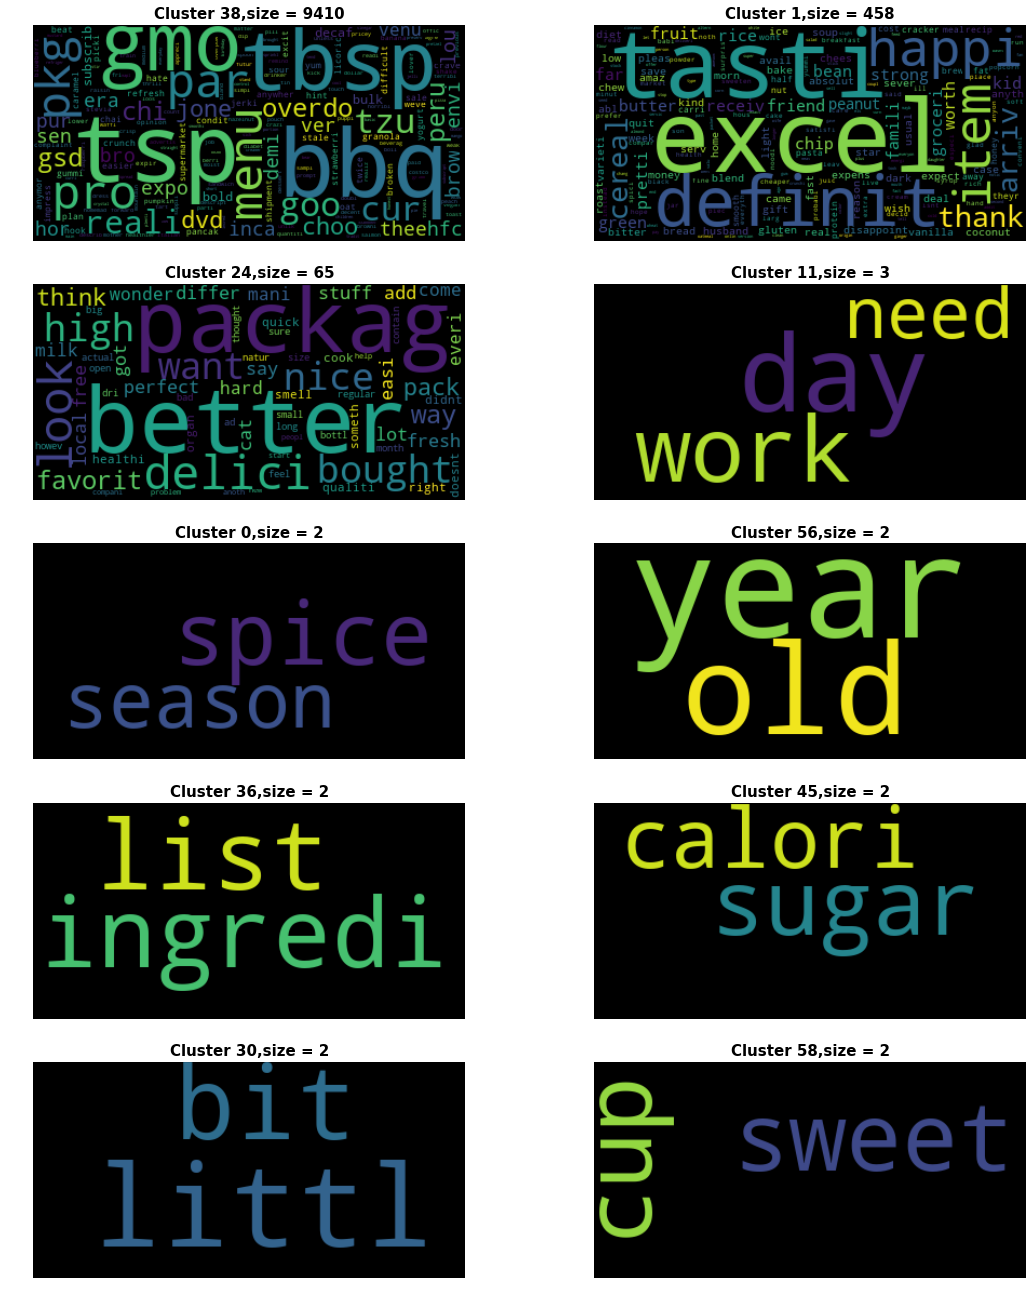

In [68]:
words_visualisation(U3,top_features_10000,labels3)

## [5] Conclusion :
(1) Co-occurence matrix for top 2k,5k and 10k words(Tfidf vectorization) is computed.  
(2) Co-occurence matrix is decomposed to obtain word vector matrix by using Truncated SVD.  
(3) Kmeans Clustering is applied with 50 clusters for wordvectors obtained.  
(4) Some pattern of clusters like nutrition,grains,grocery,sweets,snacks,spicy products are obtained.  
(5) It is also observed that words that have semantic meaning are grouped to one cluster.  
(6) As the number of top words increases from 2k to 10k, it is observed that we start losing pattern of clusters. It can be seen when we take 10k top words, lot of clusters have only one word which dont give any information. 